# Attention Mechanism Demo on Keras: Machine Translation Example (Many-to-Many, encoder-decoder)

In this demo, we will show you how to create a machine translator using Keras. This demo is inspired by Andrew Ng's deeplearning.ai course on sequence models. (Programming Assignment: Neural Machine Translation with Attention)    In this demo, we create a machine translator to translate dates in various formats  into dates in an ISO format. 

In [1]:
%matplotlib inline

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import numpy as np

import random


2.4.1


## Generate Dataset
We generate a toy dataset using datetime library.  A target output only comes in one format (iso format), while there are three different date format for an input.

In [2]:
#Generating a toy dataset
import datetime
base = datetime.datetime.today()
base = datetime.date(base.year, base.month, base.day)
date_list = [base - datetime.timedelta(days=x) for x in range(0, 15000)]

In [3]:
target_date_list = [date.isoformat() for date in date_list] 
print(target_date_list[0])

2021-03-19


In [4]:
from random import randint
random.seed(42)
input_date_list = list()
for date in date_list:
    random_num = randint(0, 2)
    if random_num == 0:
        input_date_list.append(date.strftime("%d/%m/%y"))#"11/03/02"
    elif random_num == 1:
        input_date_list.append(date.strftime("%A %d %B %Y")) #"Monday 11 March 2002"
    elif random_num == 2: 
        input_date_list.append(date.strftime("%d %B %Y")) #"11 March 2002"

In [5]:
for input_sample, target_sample in zip(input_date_list[0:10],target_date_list[0:10]):
    print(input_sample,target_sample)

19 March 2021 2021-03-19
18/03/21 2021-03-18
17/03/21 2021-03-17
16 March 2021 2021-03-16
Monday 15 March 2021 2021-03-15
14/03/21 2021-03-14
13/03/21 2021-03-13
12/03/21 2021-03-12
11 March 2021 2021-03-11
10/03/21 2021-03-10


In [6]:
#Preprocessing
input_chars = list(set(''.join(input_date_list)))
output_chars = list(set(''.join(target_date_list)))

# +1 for padding
data_size, vocab_size = len(input_date_list), len(input_chars)+1 
output_vocab_size = len(output_chars)+1

print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(input_date_list, key=len)) #max input length

There are 15000 lines and 42 unique characters in your input data.


In [7]:
print("Max input length:", maxlen)

Max input length: 27


In [8]:
sorted_chars= sorted(input_chars)
sorted_output_chars= sorted(output_chars)
sorted_chars.insert(0,"<PAD>") #PADDING for input
sorted_output_chars.insert(0,"<PAD>") #PADDING for output
#Input
char_to_ix = { ch:i for i,ch in enumerate(sorted_chars) }
ix_to_char = { i:ch for i,ch in enumerate(sorted_chars) } #reverse dictionary
#Output
output_char_to_ix = { ch:i for i,ch in enumerate(sorted_output_chars) }
ix_to_output_char = { i:ch for i,ch in enumerate(sorted_output_chars) } #reverse dictionary

print(ix_to_char)

{0: '<PAD>', 1: ' ', 2: '/', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: 'A', 14: 'D', 15: 'F', 16: 'J', 17: 'M', 18: 'N', 19: 'O', 20: 'S', 21: 'T', 22: 'W', 23: 'a', 24: 'b', 25: 'c', 26: 'd', 27: 'e', 28: 'g', 29: 'h', 30: 'i', 31: 'l', 32: 'm', 33: 'n', 34: 'o', 35: 'p', 36: 'r', 37: 's', 38: 't', 39: 'u', 40: 'v', 41: 'y'}


In [9]:
m=15000
Tx=maxlen
Ty=10

In [10]:
X = []
for line in input_date_list:
    temp=[]
    for char in line:
        temp.append(char_to_ix[char])
    X.append(temp)
Y = []
for line in target_date_list:
    temp=[]
    for char in line:
        temp.append(output_char_to_ix[char])
    Y.append(temp)    

X = pad_sequences(X,maxlen=maxlen)
# Y = pad_sequences(Y,maxlen=10)

X= to_categorical(X,vocab_size)
X=X.reshape(data_size,maxlen ,vocab_size)

Y= to_categorical(Y,output_vocab_size)
Y=Y.reshape(data_size,10 ,output_vocab_size)
print(X.shape,Y.shape)

(15000, 27, 42) (15000, 10, 12)


# Attention Mechanism
![attn_mech](https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/attn_mech.png)

In [11]:
from tensorflow.keras.activations import softmax
def softMaxAxis1(x):
    return softmax(x,axis=1)

In [12]:
#These are global variables (shared layers)
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
#Attention function###
fattn_1 = Dense(10, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)

In [24]:
def one_step_attention(a, s_prev):
    # print(a.shape)
    global test_s
    test_s = a
    # Repeat the decoder hidden state to concat with encoder hidden states
    s_prev = repeator(s_prev)
    concat = concatenator([a,s_prev])
    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies)
    #calculate a context vector
    context = dotor([attention_scores,a])

    return context

In [30]:
test_s.shape

TensorShape([None, 27, 64])

In [45]:
print(test_s.shape)
print(tf.split(test_s, num_or_size_splits=2, axis=0))
print(tf.split(test_s, num_or_size_splits=2, axis=-1))

(None, 27, 64)
[<KerasTensor: shape=(None, 27, 64) dtype=float32 (created by layer 'tf.split_14')>, <KerasTensor: shape=(None, 27, 64) dtype=float32 (created by layer 'tf.split_14')>]
[<KerasTensor: shape=(None, 27, 32) dtype=float32 (created by layer 'tf.split_15')>, <KerasTensor: shape=(None, 27, 32) dtype=float32 (created by layer 'tf.split_15')>]


# The model
![rnn_model](https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/rnn_date.png)

In [25]:
n_h = 32 #hidden dimensions for encoder 
n_s = 64 #hidden dimensions for decoder
encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer

In [26]:
print(Tx)
print(Ty)
print(n_h)
print(n_s)

27
10
32
64


In [27]:
def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)

    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

In [28]:
model = model(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 42)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 27, 64)       19200       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 27, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                 

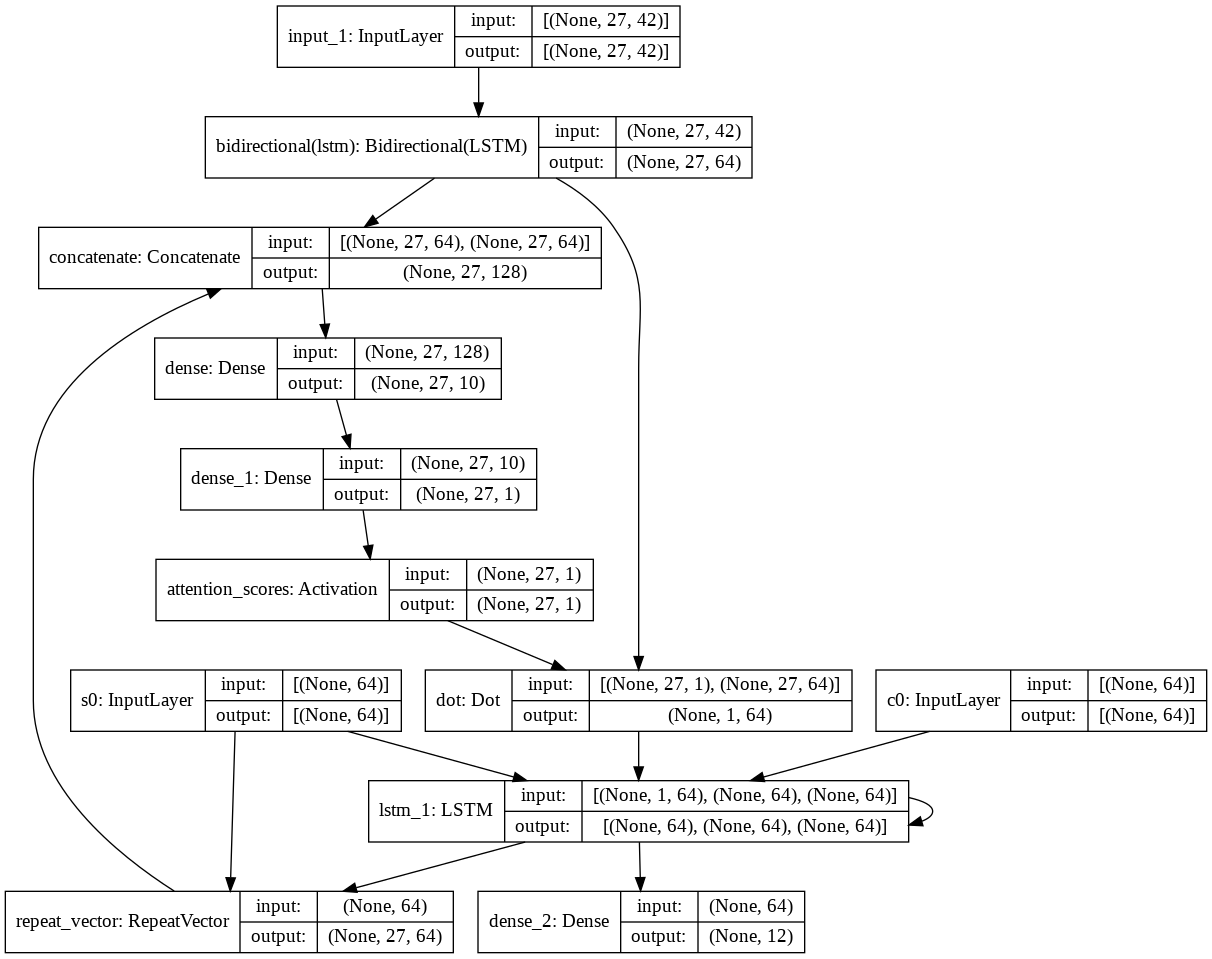

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
opt = Adam(lr= 0.01, clipvalue=0.5)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Y.swapaxes(0,1))

In [ ]:
Y.shape

(15000, 10, 12)

In [ ]:
outputs[0].shape

(15000, 12)

In [ ]:
len(outputs)

10

In [ ]:
model.fit([X, s0, c0], outputs, epochs=20, batch_size=120)

Epoch 1/20
125/125 [==============================] - 47s 28ms/step - loss: 16.6818 - dense_2_loss: 1.1788 - dense_2_1_loss: 0.9644 - dense_2_2_loss: 1.4755 - dense_2_3_loss: 2.5885 - dense_2_4_loss: 0.9734 - dense_2_5_loss: 1.3659 - dense_2_6_loss: 2.6014 - dense_2_7_loss: 1.0651 - dense_2_8_loss: 1.7963 - dense_2_9_loss: 2.6726 - dense_2_accuracy: 0.5162 - dense_2_1_accuracy: 0.7238 - dense_2_2_accuracy: 0.4363 - dense_2_3_accuracy: 0.1252 - dense_2_4_accuracy: 0.7930 - dense_2_5_accuracy: 0.3469 - dense_2_6_accuracy: 0.0783 - dense_2_7_accuracy: 0.8073 - dense_2_8_accuracy: 0.1948 - dense_2_9_accuracy: 0.0719
Epoch 2/20
125/125 [==============================] - 4s 28ms/step - loss: 6.6359 - dense_2_loss: 0.0737 - dense_2_1_loss: 0.0696 - dense_2_2_loss: 0.4518 - dense_2_3_loss: 1.3836 - dense_2_4_loss: 0.0069 - dense_2_5_loss: 0.2452 - dense_2_6_loss: 1.6194 - dense_2_7_loss: 0.0084 - dense_2_8_loss: 0.6035 - dense_2_9_loss: 2.1738 - dense_2_accuracy: 0.9686 - dense_2_1_accuracy: 0

# Let's do some "translation"

In [ ]:
def prep_input(input_list):
    X = []
    for line in input_list:
        temp=[]
        for char in line:
            temp.append(char_to_ix[char])
        X.append(temp)
    X = pad_sequences(X,maxlen=maxlen)
    X= to_categorical(X,vocab_size)
    X=X.reshape(len(input_list),maxlen ,vocab_size)
    
    return X

EXAMPLES = ['3 May 1999', '05 October 2009', '30 August 2016', '11 July 2000', 'Saturday 19 May 2018', '3 March 2001', '1 March 2001']
s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
EXAMPLES = prep_input(EXAMPLES)

prediction = model.predict([EXAMPLES , s0, c0])
prediction = np.swapaxes(prediction,0,1)
prediction = np.argmax(prediction, axis = -1)

for j in range(len(prediction)):
    output = "".join([ix_to_output_char[int(i)] for i in prediction[j]])
    print(output)

1999-05-33
2009-10-05
2016-08-30
2000-07-11
2018-05-19
2001-03-30
2001-03-19
